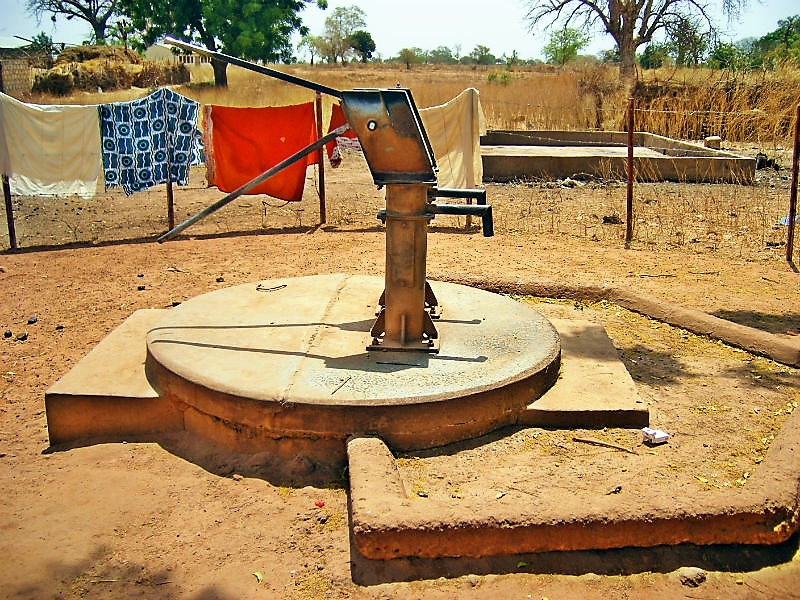

# Water Pump Functionality Analysis In Tanzania

## Purpose of Analysis

Using data from the Tanzanian Ministry of Water, our goal is to predict if water pumps are functional or non-functional.

<b>Stakeholder:</b> Tanzanian Ministry of Water

<b>Key Performance Indicator:</b> Functionality

<b>Key Metric:</b> Accuracy

## Data & Methods

<b>Data provided by DataDriven:</b> Tanzanian Ministry of Water

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate , GridSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix , accuracy_score,recall_score,f1_score,precision_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
%matplotlib inline
warnings.filterwarnings("ignore")

## EDA

In [2]:
df1 = pd.read_csv('data/Training Set Values.csv')
df2 = pd.read_csv('data/Training Set Labels.csv')
pd.set_option('display.max_columns',None)

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

We merge the data together so that we have one dataframe with predictors and target values.

In [4]:
all_data = df1.merge(df2, on='id')

In [5]:
all_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### Data Cleaning

We drop unneccessary features.

In [6]:
all_data.drop(['id', 'wpt_name', 'recorded_by', 'num_private', 'funder', 'installer', 'public_meeting'], axis=1, inplace=True)

We check if there are duplicates of the columns.

We drop scheme_name since scheme_management has more specific values.

We drop waterpoint_type_group since waterpoint_type has more specific values.

We drop extraction_type_class and extraction_type_group since extraction_type has more specific values.

We drop source_type since source has more specific values.

We drop payment_type since payment has more specific values.

We drop quantity_group since quantity has more specific values.

We drop management_group since management has more specific values.

In [7]:
all_data.drop(['waterpoint_type_group', 'scheme_name', 'extraction_type_class', 'extraction_type_group',
                'source_type',  'payment_type', 'quantity_group', 'management_group'
                ], axis=1, inplace=True)

We get year from the date_recorded and drop date_recorded.

In [8]:
all_data['recorded_year'] = all_data['date_recorded'].str[:4].astype(int)

We keep lat, long, region_code, and district_code to take location based information into account and drop region, subvillage, lga, and ward, due to very high numbers of unique values.

In [9]:
all_data.drop(['date_recorded', 'region', 'subvillage', 'lga', 'ward'], axis=1, inplace=True)

We check for null values.

In [10]:
all_data.isna().sum()

amount_tsh              0
gps_height              0
longitude               0
latitude                0
basin                   0
region_code             0
district_code           0
population              0
scheme_management    3877
permit               3056
construction_year       0
extraction_type         0
management              0
payment                 0
water_quality           0
quality_group           0
quantity                0
source                  0
source_class            0
waterpoint_type         0
status_group            0
recorded_year           0
dtype: int64

We fill null values to 'Unknown' since scheme_management and permit are objects.

In [11]:
all_data.fillna('Unknown', inplace=True)

We change permit data type from boolean to string.


In [12]:
all_data['permit'] = all_data['permit'].astype(str)

In [13]:
all_data.isna().sum()

amount_tsh           0
gps_height           0
longitude            0
latitude             0
basin                0
region_code          0
district_code        0
population           0
scheme_management    0
permit               0
construction_year    0
extraction_type      0
management           0
payment              0
water_quality        0
quality_group        0
quantity             0
source               0
source_class         0
waterpoint_type      0
status_group         0
recorded_year        0
dtype: int64

Our data is now cleaned and ready for modeling.

### Functions

In [14]:
# Makes a copy of the dataframe that has not yet converted the target variable to binary values 
# for the purpose of visualization
df_binary = all_data.copy()

# We apply the binary function to the target variable in the copy of our original dataframe
binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
df_binary['status_group'].replace(binary_key, inplace=True)

We create functions to make the calculations of metrics and the creation of visualizations easier.

In [15]:
def mean_scores(results):
    '''Return Train/Test Mean Score from a Cross Val'''
    return print(f'''Mean Train Score: {results['train_score'].mean()}
Mean Test Score: {results['test_score'].mean()}''')

def metrics(y_true,y_preds):
    '''Gives recall,precision,accuracy,F1 score and confusion matrix'''
    return print(f'''Recall Score: {recall_score(y_true,y_preds)}
Precision Score: {precision_score(y_true,y_preds)}
Accuracy Score:{accuracy_score(y_true,y_preds)}
F1 Score: {f1_score(y_true,y_preds)}
Confusion Matrix: 
{confusion_matrix(y_true,y_preds)}''')

def gs_mean_scores(results):
    '''Return Train and Test Scores from a grid search'''
    return print(f'''Mean Train Score: {results.cv_results_['mean_train_score'].mean()}'
Mean Test Score: {results.cv_results_['mean_test_score'].mean()}''')

def total_val_count(df,column):
    '''Creates a dictionary with all value counts in column'''
    data= df[column]
    counts = {}
    for i in data:
        counts[i] = counts.get(i, 0) + 1
    counts_sorted = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))
    return counts_sorted

def val_count_nf(df,column):
    '''Creates a dictionary from a dataframe that has columns
    as keys and their total count of values that do not have functioning pumps'''
    df_val = df.loc[df['status_group'] == 1]
    counts = {}
    for i in df_val[column]:
        counts[i] = counts.get(i, 0) + 1
    counts_sorted = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))
    return counts_sorted


def addlabels(x,y,left,up):
    '''Add labels on top of each bar on bar graph'''
    for i in range(len(x)):
        plt.text(i-left,y[i]+up,y[i])

def addlabelsbig(x,y,left,up):
    '''Add BIGGER labels on top of each bar on bar graph'''
    for i in range(len(x)):
        plt.text(i-left,y[i]+up,f'{y[i]}%',fontsize=20,color='black')

def percent_dict(df,column):
    '''Creates a dictionary that has highest percent of non functioning pumps'''
    percent= []
    lst = list(df[column].unique())
    for val in lst:
        num_pumps = len(df1.loc[df[column] == val])
        fail_pumps = len(df1.loc[(df['status_group'] == 1) & (df[column] == val)])
        percent.append(round((fail_pumps/num_pumps*100),2))
    d = dict(zip(lst,percent))
    d_sorted = dict(sorted(d.items(), key=lambda item: item[1],reverse=True))
    return d_sorted

def visualize(dictionary,title=None):
    '''Creates Seaborn Barplot from Dictionary'''
    nums = list(dictionary.values())
    fig , ax = plt.subplots(figsize=(12,10))
    sns.barplot(x=list(dictionary.keys()),y=nums)
    ax.set_title(title,fontsize=15)
    ax.set_ylabel('Percent Non Functioning',fontsize=15);

def stack_it(df,column,title=None,addlabels=False):
    '''Returns Barplot showing total count of catgory type with percent of failure '''

    fig , ax= plt.subplots(nrows=1,ncols=1,figsize=(12,8))
    
    
    column_count = total_val_count(df,column)
    nums = list(column_count.values())[:5]
    top_5 = list(column_count.keys())[:5]
    transform = val_count_nf(df,column)
    num_failed = []
    for x in top_5:
        for y in transform.keys():
            if x == y:
                num_failed.append(transform[y])
    percent_failed = [round((i / j)*100,1) for i, j in zip(num_failed, nums)]
    
    ax.set_title(title,fontsize=15)
    sns.barplot(x=top_5,y=nums,alpha=.4,label='Total Count',color='orange')
    ax.set_ylabel('Total Count',fontsize=15)
    sns.barplot(x=top_5, y=num_failed,label='Amount Failed',color='orange')
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(fontsize=15)
    if addlabels:        
        addlabelsbig(top_5,percent_failed,.2,100);

### Data Visualization

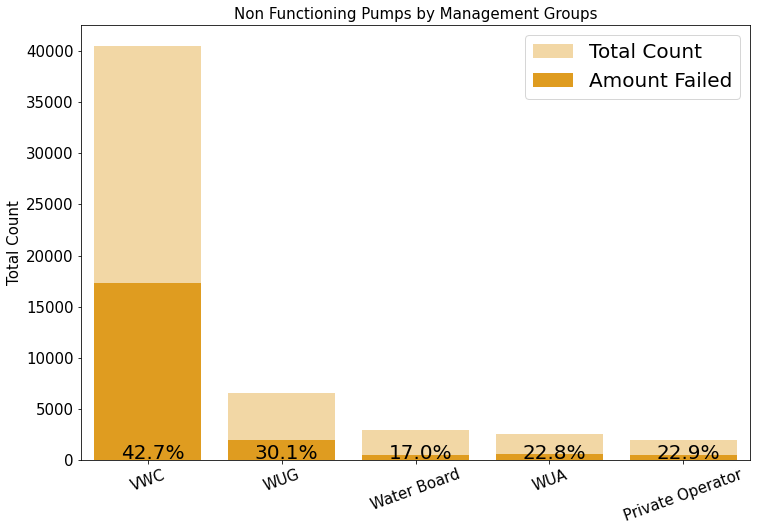

In [16]:
stack_it(df_binary,'management',addlabels=True,title='Non Functioning Pumps by Management Groups')
plt.legend(fontsize=20)

plt.xticks([0, 1, 2, 3 ,4], ['VWC', 'WUG', 'Water Board', 'WUA', 'Private Operator'],
    rotation=20);


We speculate that the company managing a well may have an impact on the percentage of failed pumps. VWC seems to be leading the way with almost 43% of their wells being non functional.

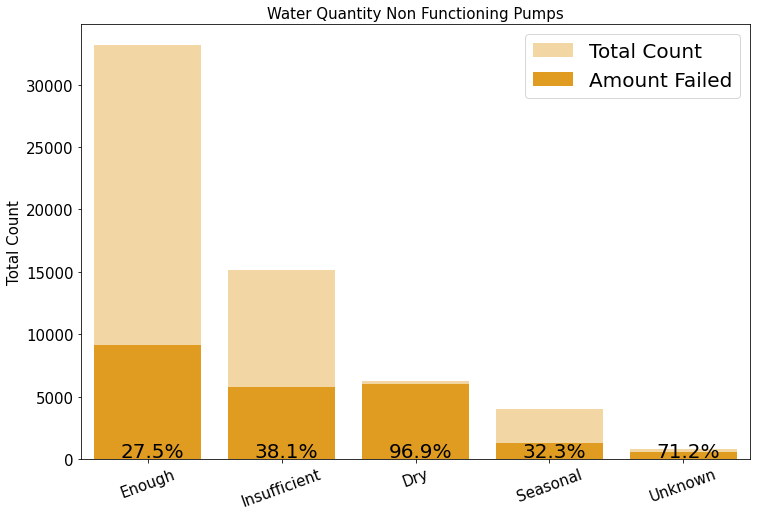

In [17]:
stack_it(df_binary,'quantity',addlabels=True,title='Water Quantity Non Functioning Pumps')
plt.xticks([0, 1, 2, 3 ,4], ['Enough', 'Insufficient', 'Dry', 'Seasonal', 'Unknown'],
    rotation=20)

plt.legend(fontsize=20);


Dry wells have the highest percentage of non functioning wells, at just about 97%. It is also interesting that waterpoints labeled as insufficient water have the second highest percentage of non functional wells. It seems the less water a well has, the higher the chance the pump is non functional.

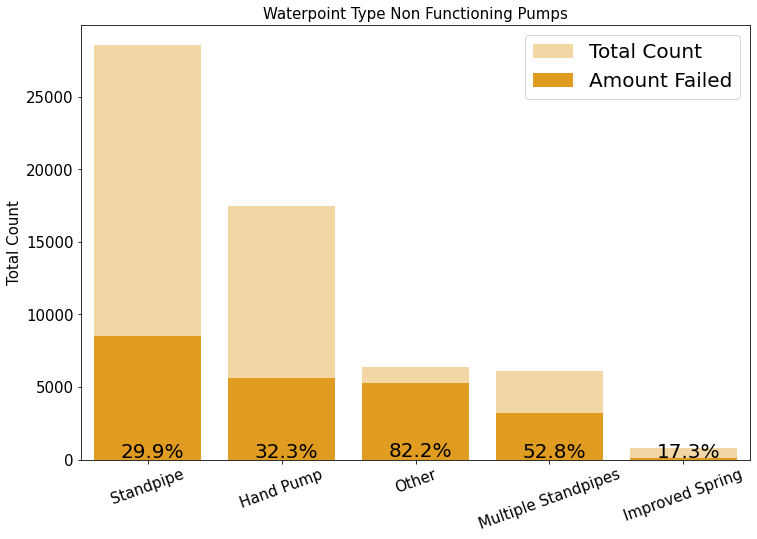

In [18]:
stack_it(df_binary,'waterpoint_type',addlabels=True,title='Waterpoint Type Non Functioning Pumps')
plt.legend(fontsize=20)

plt.xticks([0, 1, 2, 3 ,4], ['Standpipe','Hand Pump','Other','Multiple Standpipes','Improved Spring'],
    rotation=20);


We found that waterpoint type is a good indicator of a well's functionality. If a waterpoint has multiple standpumps, there is over a 50% chance that the pump will be non functional. In the future, we would try to identify the 'Other' category to see which pumps are performing the worst.

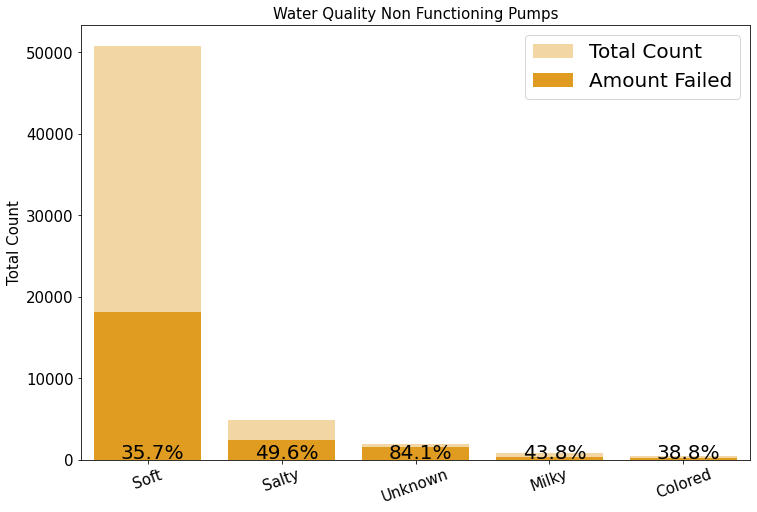

In [19]:
stack_it(df_binary,'water_quality',title='Water Quality Non Functioning Pumps',addlabels=True)
plt.legend(fontsize=20)

plt.xticks([0, 1, 2, 3 ,4], ['Soft','Salty','Unknown','Milky','Colored'],
    rotation=20);


Here we see that wells containing salty water have the second highest percentage of non functional wells compared to those with water of different quality. We expect water with higher solid contents (such as saltwater) to influence a higher percentage of non functional wells, because of the wear and tear caused by the solids in the water. 

Unknown water types have the highest percentage of non functional wells. In the future, we would try to identify those unknown water types, as we think more solids in the water leads to a higher percentage of non functional wells. Other things (like flow rates) would affect the percentage of non functional wells too. The faster the solids move in water, the more damage they will do to the wells.  

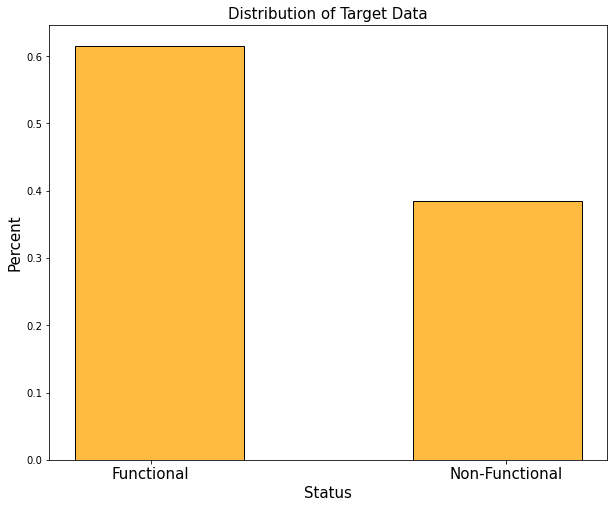

In [20]:
#Look at the distribution of our target data

fig , ax = plt.subplots(figsize=(10,8))

sns.histplot(df_binary['status_group'],stat='probability',bins=3,color='orange')
plt.xticks([.15,.85],['Functional','Non-Functional'],fontsize=15)

ax.set_title('Distribution of Target Data',fontsize=15)
ax.set_xlabel('Status',fontsize=15)
ax.set_ylabel('Percent',fontsize=15);


Our target variable is split roughly 60/40 between functional and non functional wells, ~60% being functional, and ~40% being non functional. Given this split, we do not see the need to use any class balancers.

## Model Selection

### Train-Test Split

In [21]:
X = all_data.drop('status_group', axis=1)
y = all_data['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

We map our target values to binary.

In [22]:
y_train = y_train.map({'functional' : 0, 'non functional' : 1, 'functional needs repair' : 0})

We create an age column to get to account for the effect of time on the funcitonality of the water wells.

In [23]:
# Replace water pumps with 0 construction year with the median construction year
median_year_with_no_zero = X_train[X_train['construction_year'] > 0]['construction_year'].median()
X_train.loc[(X_train['construction_year'] == 0),'construction_year'] = median_year_with_no_zero

# If construction year is greater than recorded age, than replace construction year with median year.
X_train.loc[(X_train['construction_year'] > X_train['recorded_year']),'construction_year'] = median_year_with_no_zero

# Create age column
X_train['age'] = X_train['recorded_year'] - X_train['construction_year']

# Drop recorded_year and construction_year since we now have the age
X_train.drop(['recorded_year', 'construction_year'], axis=1, inplace=True)

### Dummy Classifier

We fit a dummy classifier to get our baseline model.

In [24]:
# Create our dummy model
dummy_model = DummyClassifier(strategy="most_frequent")

cv_results = cross_validate(dummy_model, X_train, y_train, return_train_score=True)

In [25]:
mean_scores(cv_results)

Mean Train Score: 0.6157575757575758
Mean Test Score: 0.6157575757575758


The dummy classifier model has a prediciton accuracy of ~61.6%.

### Logistic Regression

We create a logistic regression model to try to get an improvement in predictive power.

In [26]:
# Get categorical and numeric columns
categorical_cols = X_train.select_dtypes('object')
numerical_cols = X_train.select_dtypes(exclude=['object'])

# Create a pipeline for categorical (OneHotEncoder) and numeric columns (StandardScaler)
categorical_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])
numerical_pipeline = Pipeline(steps=[('ss', StandardScaler())])

# Create transformer with both categorical and numeric pipelines
trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, numerical_cols.columns),
    ('categorical', categorical_pipeline, categorical_cols.columns)
])

# Create a pipeline with the transformer and the model
lr_pipline = Pipeline(steps=[('trans', trans),
                              ('model', LogisticRegression(random_state=42))])

In [27]:
# Create a grid search to get the best hyperparameters for the logistic regression model
lr_grid = {'model__C' : [0.5, 1, 50],
       'model__max_iter' : [1750, 2000],
       'model__class_weight': [None, 'balanced', 0.25],
       'model__tol' : [0.0001, 0.01, 0.1]}

lr_gs = GridSearchCV(lr_pipline, lr_grid, cv=3, return_train_score=True)

In [28]:
# Fit our data into the grid search
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'age'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index([...n_type', 'management

In [29]:
# Check the best hyperparameters
lr_gs.best_params_

{'model__C': 50,
 'model__class_weight': None,
 'model__max_iter': 1750,
 'model__tol': 0.1}

In [30]:
gs_mean_scores(lr_gs)

Mean Train Score: 0.7929704451926674'
Mean Test Score: 0.7914020867107289


Our logistic regression model has a prediction accuracy of ~79%. Looking at the mean train and test scores, the variance is very low, and compared to the baseline model, the amount of bias has decreased.

In [31]:
lr_y_pred = cross_val_predict(lr_gs.best_estimator_, X_train, y_train)

metrics(y_train,lr_y_pred)

Recall Score: 0.5984928145811427
Precision Score: 0.8191412808827057
Accuracy Score:0.794949494949495
F1 Score: 0.6916455696202531
Confusion Matrix: 
[[25170  2262]
 [ 6873 10245]]


The logistic model predicts 35,424 water wells correctly. On the other hand, the model predicts 6,873 water wells as non-functional when they are functional, and 2,262 water pumps as functional when they are non-functional.

### K Nearest Neighbors

We create a KNN model in an effort to improve predictive accuracy.

In [32]:
# Create pipeline with the transformer and KNN model
knn_pipline = Pipeline(steps=[('trans', trans),
                              ('model', KNeighborsClassifier())])

In [33]:
# Create grid search to get the best parameters for KNN
knn_grid= {'model__n_neighbors': [7,11,15,21],
      'model__weights': ['distance', 'uniform'],
      }

knn_gs = GridSearchCV(knn_pipline, knn_grid, cv=3, return_train_score=True)

# Fit our training data in the grid search
knn_gs.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'age'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['basin', 'scheme_manage

In [34]:
# Check the best hyperparameters
knn_gs.best_params_

{'model__n_neighbors': 15, 'model__weights': 'distance'}

In [35]:
gs_mean_scores(knn_gs)

Mean Train Score: 0.9180331088664422'
Mean Test Score: 0.8168237934904602


Our KNN model has a prediction accuracy of ~81.6%. Looking at the mean train and test scores, the variance is high, but compared to the previous two models, the bias is slightly lower. However, the model seems to be overfit.

In [36]:
knn_y_pred = cross_val_predict(knn_gs.best_estimator_, X_train, y_train)

metrics(y_train, knn_y_pred)

Recall Score: 0.7315106905012267
Precision Score: 0.8131168831168831
Accuracy Score:0.8322334455667789
F1 Score: 0.7701580663017406
Confusion Matrix: 
[[24554  2878]
 [ 4596 12522]]


The KNN model predicts 37,076 water pumps correctly. Conversely, the model predicts 4,596 water pumps as non-functional when they are functional and 2,878 water pumps as functional when they are non-functional.

### Random Forest Classifier

We create a RandomForestClassifier to see if we can reduce variance while simultaneously reducing bias.

In [37]:
# Create transformers for only categorical columns (OneHotEncoder) since random forests do not need scaled data
ohe_trans = ColumnTransformer(transformers=[('categorical', categorical_pipeline, categorical_cols.columns)],
                              remainder='passthrough')
# Create pipeline with transformer and randomforest model
forest_pipline = Pipeline(steps=[('ohe_trans', ohe_trans),
                              ('model', RandomForestClassifier(random_state=42))])

In [38]:
# Create grid search to get the best hyperparameters for our random forest model
forest_grid= {'model__criterion':['gini', 'entropy'],
         'model__max_depth':[None,3,5],
         'model__min_samples_split':[2,5,10],
         'model__min_samples_leaf':[1,3,5,7],
         'model__max_features' : [5,10]}

forest_gs = GridSearchCV(forest_pipline, forest_grid, cv=3, return_train_score=True)

# Fit the training data in the grid search
forest_gs.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ohe_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['basin', 'scheme_management', 'permit', 'extraction_type', 'management',
       'payment', 'water_quality', 'quality_group', 'quantity', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model

In [39]:
# Check the best hyperparameters
forest_gs.best_params_

{'model__criterion': 'gini',
 'model__max_depth': None,
 'model__max_features': 10,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 5}

In [40]:
gs_mean_scores(forest_gs)

Mean Train Score: 0.8008793178700587'
Mean Test Score: 0.7836664484349669


Our random forest classifier model has a prediction accuracy of ~78%. Looking at the mean train and test scores, the variance is low, however, the bias is higher than than the KNN model and the logistic model.

In [41]:
forest_y_pred = cross_val_predict(forest_gs.best_estimator_, X_train, y_train)

metrics(y_train, forest_y_pred)

Recall Score: 0.7574483000350508
Precision Score: 0.8454616588419406
Accuracy Score:0.8536026936026936
F1 Score: 0.7990386393048622
Confusion Matrix: 
[[25062  2370]
 [ 4152 12966]]


Our random forest classifier model predicts 38,028 water pumps correctly. On the other hand, the model predicts 4,152 water pumps as non-functional when they are functional, and 2,370 water pumps as functional when they are non-functional.

### XGBoost

We create an XGBoost model in an attempt to lower bias, while keeping variance low.

In [42]:
# Create pipeline with transformer and XGBoost model
xgb_pipeline = Pipeline(steps=[('ohe_trans', ohe_trans),
                               ('model', XGBClassifier(random_state=42))])

In [43]:
# Create a grid search to find the best hyperparameters
xgb_grid = {'model__n_estimators':[50,75,100],
            'model__max_depth':[1,3,4,5]}

xgb_gs = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_grid, cv=3, return_train_score=True)

# Fit the training data to the grid search
xgb_gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ohe_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['basin', 'scheme_management', 'permit', 'extraction_type', 'management',
       'payment', 'water_quality', 'quality_group', 'quantity', 'source',
       'source_class', 'wate...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                           

In [44]:
# Check the best hyperparameters
xgb_gs.best_params_

{'model__max_depth': 5, 'model__n_estimators': 100}

In [45]:
gs_mean_scores(xgb_gs)

Mean Train Score: 0.8267433595211373'
Mean Test Score: 0.813791619902731


Our XGBoost model has a prediction accuracy of ~81%. Looking at mean the train and test scores, the variance is relatively low, while producing a lower bias than the dummy classifier, logistic regression, and random forest classifier. 

In [46]:
xgb_y_pred = cross_val_predict(xgb_gs.best_estimator_, X_train, y_train)

metrics(y_train, xgb_y_pred)

Recall Score: 0.695291506017058
Precision Score: 0.8591640799826752
Accuracy Score:0.8391245791245792
F1 Score: 0.76858997126344
Confusion Matrix: 
[[25481  1951]
 [ 5216 11902]]


#### Tweaking the hyperparameters

We change the hyperparameters put into the grid search in an effort to lower bias in the XGBoost model further.

In [47]:
xgb_grid2 = {'model__n_estimators':[150,200,225,240],
            'model__max_depth':[4,5,6,7]}

xgb_gs2 = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_grid2, cv=3, return_train_score=True)

xgb_gs2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ohe_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['basin', 'scheme_management', 'permit', 'extraction_type', 'management',
       'payment', 'water_quality', 'quality_group', 'quantity', 'source',
       'source_class', 'wate...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                           

In [48]:
# Check the best hyperparameters
xgb_gs2.best_params_

{'model__max_depth': 7, 'model__n_estimators': 200}

In [49]:
gs_mean_scores(xgb_gs2)

Mean Train Score: 0.9066813973063973'
Mean Test Score: 0.8427272727272728


Our second XGBoost model with the new set of hyperparameters has a prediction accuracy of ~84%. Looking at the mean train and test scores, the variance is relatively higher than the other models, however, the bias is lower than all of the other models.

In [50]:
xgb2_y_pred = cross_val_predict(xgb_gs2.best_estimator_, X_train, y_train)

metrics(y_train, xgb_y_pred)

Recall Score: 0.695291506017058
Precision Score: 0.8591640799826752
Accuracy Score:0.8391245791245792
F1 Score: 0.76858997126344
Confusion Matrix: 
[[25481  1951]
 [ 5216 11902]]


Our XGBoost model predicts 37,772 water pumps correctly. Conversely, the model predicts 4,474 water pumps as non-functional when they are functional, and 2,304 water pumps as functional when they are non-functional.

### Best Model - XGBoost

Our second XGBoost model produced the best test score of all of our models, while having manageable variance. Based on its performance, we selected it as our final model and tested its performance on the unseen testing data.

In [51]:
# Make our target binary, create age column, and drop year_recorded and construction_year
y_test = y_test.map({'functional' : 0, 'non functional' : 1, 'functional needs repair' : 0})
median_year_with_no_zero = X_test[X_test['construction_year'] > 0]['construction_year'].median()
X_test.loc[(X_test['construction_year'] == 0),'construction_year'] = median_year_with_no_zero
X_test.loc[(X_test['construction_year'] > X_test['recorded_year']),'construction_year'] = median_year_with_no_zero
X_test['age'] = X_test['recorded_year'] - X_test['construction_year']
X_test.drop(['recorded_year', 'construction_year'], axis=1, inplace=True)

In [52]:
# Get accuracy score for the best model
xgb_gs2.score(X_test, y_test)

0.857979797979798

Our best model produced a prediction accuracy of ~85.8%.

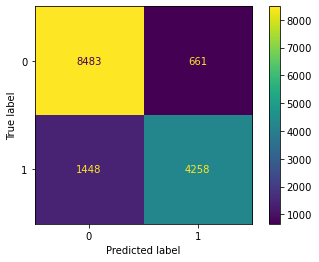

In [53]:
plot_confusion_matrix(xgb_gs2, X_test, y_test)

Our second XGBoost model predicts 12,741 water wells in the testing data correctly. The model predicts 1,458 water wells as non-functional when they are functional, and 661 wells as functional when they are non-functional.

#### Feature Importance

We investigate the most important features of our best model.

In [54]:
best_model = xgb_gs2.best_estimator_.fit(X_train, y_train)

In [55]:
# Get column names including onehotencoded columns
ohe_col_names = list(best_model.named_steps['ohe_trans'].transformers_[0][1][0].get_feature_names(categorical_cols.columns))

# Combine onehotencoded columsn with numeric columns
col_names = ohe_col_names + list(numerical_cols.columns)

In [56]:
col_names

['basin_Internal',
 'basin_Lake Nyasa',
 'basin_Lake Rukwa',
 'basin_Lake Tanganyika',
 'basin_Lake Victoria',
 'basin_Pangani',
 'basin_Rufiji',
 'basin_Ruvuma / Southern Coast',
 'basin_Wami / Ruvu',
 'scheme_management_Company',
 'scheme_management_None',
 'scheme_management_Other',
 'scheme_management_Parastatal',
 'scheme_management_Private operator',
 'scheme_management_SWC',
 'scheme_management_Trust',
 'scheme_management_Unknown',
 'scheme_management_VWC',
 'scheme_management_WUA',
 'scheme_management_WUG',
 'scheme_management_Water Board',
 'scheme_management_Water authority',
 'permit_False',
 'permit_True',
 'permit_Unknown',
 'extraction_type_afridev',
 'extraction_type_cemo',
 'extraction_type_climax',
 'extraction_type_gravity',
 'extraction_type_india mark ii',
 'extraction_type_india mark iii',
 'extraction_type_ksb',
 'extraction_type_mono',
 'extraction_type_nira/tanira',
 'extraction_type_other',
 'extraction_type_other - mkulima/shinyanga',
 'extraction_type_other -

In [57]:
# Create a dataframe with the feature names and the importance of each feature
feature_importance_df = pd.DataFrame({'Features' : col_names, 'Importances' : best_model[1].feature_importances_})
feature_importance_df

,Features,Importances
0,basin_Internal,0.004314
1,basin_Lake Nyasa,0.024857
2,basin_Lake Rukwa,0.020311
3,basin_Lake Tanganyika,0.002254
4,basin_Lake Victoria,0.003165
...,...,...
104,latitude,0.003433
105,region_code,0.009339
106,district_code,0.004833
107,population,0.003331


In [58]:
# Inspect features with importance percentages greater than 0.02
feature_importance_df[feature_importance_df['Importances'] > 0.02].sort_values(by=['Importances'], ascending=False)

,Features,Importances
76,quantity_dry,0.281667
100,waterpoint_type_other,0.129326
43,management_company,0.026243
34,extraction_type_other,0.024994
1,basin_Lake Nyasa,0.024857
31,extraction_type_ksb,0.022414
2,basin_Lake Rukwa,0.020311


We can see from the dataframe that the feature quantity_dry is the most important at about ~28.2%, with waterpoint_type_other being the second most important in the model at ~12.4%, and management_company being the thrid most important feature at ~2.6%.

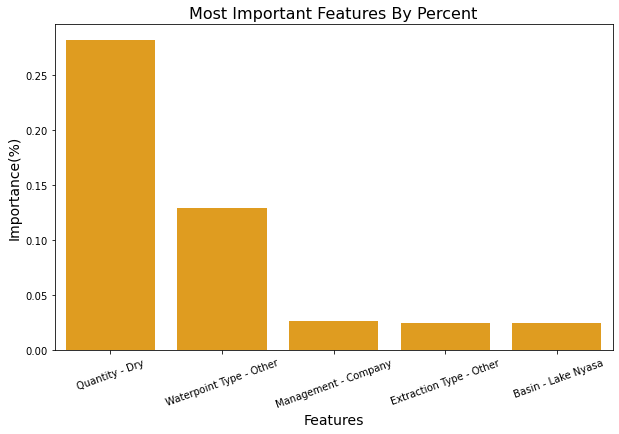

In [59]:
df_top_important = feature_importance_df.sort_values(by=['Importances'], ascending=False)[:5]
fig, ax = plt.subplots(figsize=(10,6))

x = ['Quantity - Dry', 'Waterpoint Type - Other', 'Management - Company', 'Extraction Type - Other', ' Basin - Lake Nyasa']

ax = sns.barplot(x, df_top_important['Importances'], color='orange')
ax.set_title('Most Important Features By Percent', fontsize=16)
ax.set_ylabel('Importance(%)', fontsize=14)
ax.set_xlabel('Features', fontsize=14)
plt.xticks(rotation=20);

## Conclusion

Our final model gave us a prediction accuracy of ~85.8% when predicting the functionality of a water well in Tanzania.

Given those features that have the greatest impact on the functionality of water wells in Tanzania our recommendations to the Tanzanian Ministry of Water are:

Perform regular checks on the quantity of water in the wells, and take preventative measures to decrease the chances of them being non-functional.

Replace waterpoint types with the designation of ‘other’ with more effective and widespread types, like gravity waterpoints.

Put policies in place that ensure the company managing a well are performing regular checks and maintenance. Screen companies seeking to construct a well using a rigorous standard to decide if their project may go forward.


## Future Steps

Identify the categories of certain features that are labeled as ‘other’ and ‘unknown’. This will create more clarity and specificity within the dataset, and theoretically, a model that can make even more accurate predictions.

Use machine learning to create a model that predicts the quantity of water in a well, dry or not, to help the Tanzanian Ministry of Water be more proactive in performing checks and maintenance.

Determine the impact of funders on the functionality of water wells.